# Discrimination of biological sex from urinary metabolic profiles using Random Forests

Random forest alternative to the PLS-DA analysis performed in the **Discrimination of biological sex from urinary metabolic profiles using Partial Least Squares – Discriminant Analysis** notebook.

Latent variable methods, such as PCA and Partial Least squares, are very popular in chemometrics and data analysis of metabolic profiling data. However, there are many other alternative multivariate statistical and machine learning methods which could be used. In theory, any method which is capable to handling problems where there are more variables than the observations ($p<<n$) and multicolinearity could be used, as long as robust model validation procedures are followed (e.g. cross-validation). For example, regularized regression models (ridge regression or LASSO), support vector machines (SVM), neural networks or random forest classifiers, can be used for metabolomic data analysis. Nevertheless, there are fundamental differences in the way each of these algorithms work, their parameters, and how they should be interpreted.

In this notebook we will use a random forest classifier model to discriminate urine biofluid metabolic profiles based on the participant's sex. This analysis is analogous to the one performed in the **Discrimination of biological sex from urinary metabolic profiles using Partial Least Squares – Discriminant Analysis** notebook.

The notebook is divided in the following steps:

1) RF classifier training basics: Fit a random forest classifier model using default parameter recommendations, and explore the impact of the parameters in the RF algorithm.

2) Model cross-validation and parameter selection: Describe model cross-validation, robust parameter selection with double-cross validation and performance assessment for a random forest model.

3) Model interpretation: Describe some of the available variable importance metrics for Random Forest models, and highlight which variables are different between male and female. Compare the results with those from a PLS-DA analysis (performed using the notebook **Discrimination of biological sex from urinary metabolic profiles using Partial Least Squares – Discriminant Analysis**)

In [1]:
# Code import
# Import all the packages and configure notebook plotting mode.

# Import the required python packages
import numpy as np
from sklearn import preprocessing
import pandas as pds
import matplotlib.pyplot as plt
import warnings
from sklearn.ensemble import RandomForestClassifier
from sklearn import tree

from sklearn.model_selection import cross_validate, StratifiedKFold, GridSearchCV, permutation_test_score, cross_val_predict
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, roc_curve, RocCurveDisplay, auc
from sklearn.inspection import permutation_importance

np.random.seed(350)

The next cell sets up the figure display mode. The *notebook* mode allows interactive plotting.

In [2]:
# Set the plot backend to support interactive plotting
%matplotlib notebook

## Data import

We will now import the LC-MS RPOS Dementia  dataset together with metadata required for this example.

rpos_x_matrix - LC-MS data matrix, with observations in rows and features as columns. The data has already been normalised by probabilistic quotient normalization to account for variation in urinary dilution.

variable_names - Unique names for each LC-MS feature. Each id is a concatenation of retention time (in seconds) and m/z (retentionTime_m/z)

#### Metadata
Gender - Biological sex of the participants (Male or female)

Age - Age of the study participants, in years

In [3]:
# Load the dataset
dementia_rpos_dataset = pds.read_csv("./Data/Dementia_RPOS_XCMS.csv",delimiter=',')

rpos_x_matrix = dementia_rpos_dataset.iloc[:, 13::].values
variable_names = dementia_rpos_dataset.columns[13::]
# Use pandas Categorical type
gender_y = pds.Categorical(dementia_rpos_dataset['Gender'])

In [4]:
# Extract the retention times and m/z to use in 2D plots of the dataset
retention_times = np.array([x.split('_')[0] for x in variable_names], dtype='float')/60
mz_values = np.array([x.split('_')[1][0:-3] for x in variable_names], dtype='float')

**Note**: To apply the analyses exemplified in this notebook to any other dataset, just modify the cell above to import the data matrices and vectors X and Y from any other source file.

The expected data types and formatting for **X** and **Y** are:

   **X**: Any data matrix with n rows (observations/samples) and p columns (variables/features). The matrix should be provided as a [numpy.ndarray](https://numpy.org/doc/stable/reference/generated/numpy.ndarray.html) object, with 2 dimensions, and with shape = (n, p). We recommend using the *numpy* function [numpy.genfromtxt](https://numpy.org/devdocs/reference/generated/numpy.genfromtxt.html) or the *pandas* [pandas.read_csv](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.read_csv.html) function to read the data from a text file. When using the *pandas.read_csv* function, extract the data matrix as a *numpy.ndarray* from the pandas.DataFrame object using the `.values` attribute. 
```
X_DataFrame = pds.read_csv("./data/X_spectra.csv")
X = X_DataFrame.values
```
   
   **Y** vectors: Each **Y** vector should be a 1-dimensional [numpy.ndarray](https://numpy.org/doc/stable/reference/generated/numpy.ndarray.html) object, with a number and ordering of elements matching the rows in **X**. For continuous variables, any regular *numpy.ndarray* with a data type of `int` (integers only) or `float` can be used.
   ```
   Y_continuous = numpy.ndarray([23.4, 24, 0.3, -1.23], dtype='float')
   ```
To handle class labels, we recommend using the *pandas* [Categorical](https://pandas.pydata.org/pandas-docs/stable/user_guide/categorical.html) datatype. After converting a column to a `Categorical` datatype, the `.codes` attribute returns a vector with the same length of the original Y, but where each value is replaced by their integer (`int`) code. The correspondence between code and category can be inspected with the `categories` attribute. The order of the labels in `.codes` is the same as the order of the `categories` attribute (i.e. 0 is the first element in `categories`, 1 the second and so on).
   ```
   Y1 = pds.Categorical(Y.iloc[:, 1])
   Y1.codes # The numerical label
   Y1.categories # Original text or numerical description of the category
   ```

### Plotting the dataset 

The next cell will plot in 2-dimensions (retention time and m/z) the features on the reversed phased positive (RPOS) LC-MS dataset. High resolution LC-MS datasets are very complex, with numbers of features routinely exceeding > 10,000. Visualization of the raw dataset or even derived peak picked data sets is not straightforward. 2D scatter plots, such as the one shown below can be used to project quantities, of interest from multivariate and machine learning models, to get an overview of the co-elution patterns and m/z ranges from the detected signatures.

**Note**: 2D scatterplots contain a large number of datapoints. We recommend closing the plot after inspection by using the "power" button in the top right corner of the figure frame, to avoid performance issues when opening multiple plots.

<IPython.core.display.Javascript object>


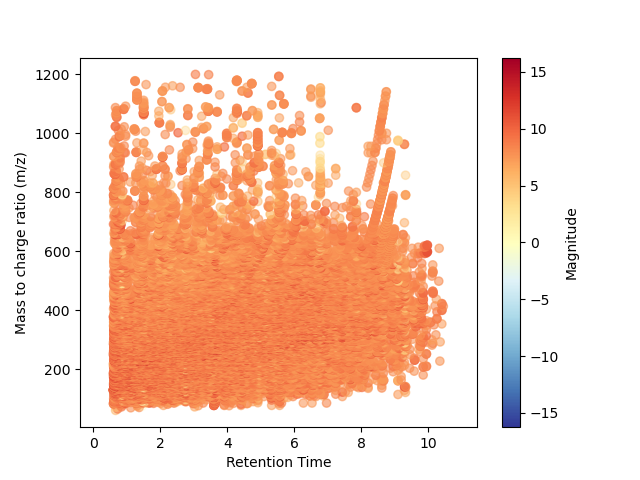

(<Figure size 640x480 with 2 Axes>,
 <AxesSubplot:xlabel='Retention Time', ylabel='Mass to charge ratio (m/z)'>)

In [5]:
# Plot the spectra in the dataset
from pyChemometrics.plotting_utils import _scatterplots
# Helper 2D plot function from pyChemometrics
_scatterplots(np.log(np.mean(rpos_x_matrix, axis=0) + 1), xaxis=retention_times, yaxis=mz_values)

# Random Forest Classifier

## 1) Model fitting basics

In this section we will train a Random Forest classifier to predict the sex of the participant based on their urine biofluid metabolic phenotypes and assess the metabolic differences between males and females.

Random forests are an ensemble classification algorithm, which agglomerates the predictions of multiple individual models to generate a final consensus prediction. In this case, the models whose predictions are being used to estimate the final prediction are decision trees. 

Each decision tree is trained on a random sample of the dataset (does not use the entire dataset), and the node splits are decided based only a subset of the variables, also chosen randomly. Even if the individual trees can overfit, by pooling together the predictions of all these classifiers, .

For more information we recommend reading the original RF manuscript by [Breiman](https://doi.org/10.1023/A:1010933404324). In this notebook we will use the scikit-learn implementation of [random forests](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html)

The main parameters to consider when fitting a random forest classifier as implemented in scikit-learn are:

**n_estimators**: Number of decision trees in the forest. A higher number of trees improves the capacity of the model to fit the data, at the expense of computation time. Increasing the number of trees is generally safe when it comes to overfitting, and the main trade-off is computation time. 

**max_features**: Number of randomly selected features to calculate at each tested split. A very small value can cause underfitting (low probability of finding a meaningfull variable to use in the decision tree), while setting the value to the total number of features can cause overfitting (individual trees are optimized using all variables), especially when combined with large tree depth. 

**max_depth**: Maximum depth of the tree (in number of splits). Trees with higher depth, can fit the data better and learn more characterististics from the dataset, but also have a higher likelihood of overfitting. 

**min_sample_split** and **min_sample_leaf**: Number of samples required to accept a split at any point in the tree and at the final leaf node, respectively. Decreasing these parameters can improve the performance of the random forest ensemble, but this comes with a higher risk of overfitting. 

In addition to these, [scikit-learn's random forest classifier](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html) implementation provides other parameters which can be used to fine-tune the proporties of the trees. These are not discussed here, but most of them indirectly adjust the complexity of decision trees.

Unlike PCA and PLS-DA, variable/column scaling does not impact on the classifier performance. For this example, for easier comparison with the PLS-DA analysis, we will also log-transform the dataset.

In [6]:
# Select the scaling options: 
offset = np.min(rpos_x_matrix) + 1
log_X = np.log(rpos_x_matrix + offset)

In [7]:
# Create and train a random forest classifier model
RF_Classifier = RandomForestClassifier(n_estimators=250, max_features='auto', 
                                       max_depth=100, oob_score=True, n_jobs=8)

RF_Classifier.fit(log_X, gender_y)

RandomForestClassifier(max_depth=100, n_estimators=250, n_jobs=8,
                       oob_score=True)

Example decision tree from the random forest classifier.

<IPython.core.display.Javascript object>


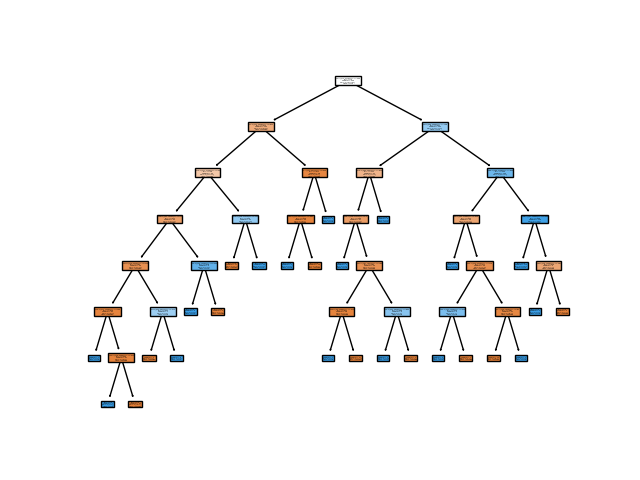

In [8]:
fig, ax = plt.subplots()

tree.plot_tree(RF_Classifier.estimators_[0], 
               feature_names=variable_names,
               class_names=gender_y.categories,
               filled = True,ax=ax)
plt.show()

In the following cells we will compare examples of individual decision trees from random forest classifiers instances trained with different parameters. 

Setting *max_depth=2* ensures the trees grown do not exceed more than 2 splits in any branch.

In [9]:
RF_Classifier = RandomForestClassifier(n_estimators=250, max_features='auto', 
                                       max_depth=None, oob_score=True, n_jobs=8)
RF_Classifier.fit(log_X, gender_y)

RF_Classifier_dep2 = RandomForestClassifier(n_estimators=250, max_features='auto', 
                                       max_depth=2, oob_score=True, n_jobs=8)
RF_Classifier_dep2.fit(log_X, gender_y)

RandomForestClassifier(max_depth=2, n_estimators=250, n_jobs=8, oob_score=True)

<IPython.core.display.Javascript object>


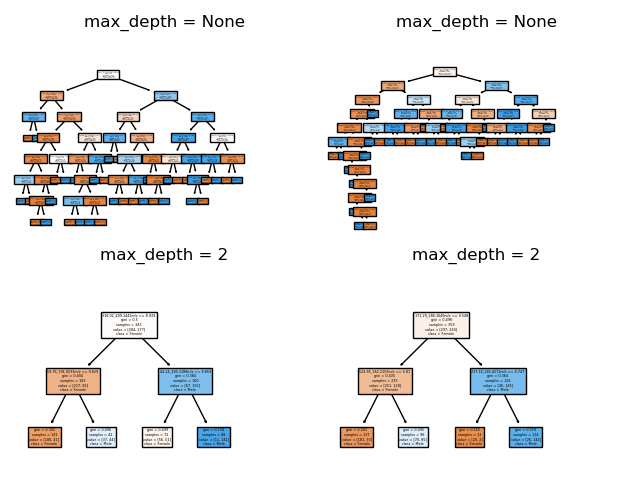

In [10]:
fig, ax = plt.subplots(2,2)

tree.plot_tree(RF_Classifier.estimators_[100], 
               feature_names=variable_names,
               class_names=gender_y.categories,
               filled = True,ax=ax[0,0])

tree.plot_tree(RF_Classifier.estimators_[50], 
               feature_names=variable_names,
               class_names=gender_y.categories,
               filled = True,ax=ax[0,1])

tree.plot_tree(RF_Classifier_dep2.estimators_[100], 
               feature_names=variable_names,
               class_names=gender_y.categories,
               filled = True,ax=ax[1,0])

tree.plot_tree(RF_Classifier_dep2.estimators_[50], 
               feature_names=variable_names,
               class_names=gender_y.categories,
               filled = True,ax=ax[1,1])

ax[0, 0].set_title('max_depth = None')
ax[0, 1].set_title('max_depth = None')
ax[1, 0].set_title('max_depth = 2')
ax[1, 1].set_title('max_depth = 2')

fig.tight_layout()
plt.show()

Since random forest has no dimensionality reduction features, there is no equivalent visualization to the PCA and PLS score plots. The model should be assessed in terms of its predictions and performance metrics estimated from them, such as confusion matrices or ROC curves.

**Warning**: Like most machine learning and multivariate models, overfitting is a potential issue when using random forest predictors, and cross-validation should be used to choose the model parameters and obtain a better estimate of the generalization error and model robustness. As with PLS-DA models, the predictions of the random forest classifier for data that was used to train the model should not be trusted.

An interesting feature of random forest classifiers, implemented in scikit-learn and other packages, is the estimation of out-of-bag prediction errors. Each tree is only trained using a random sub-sample of the data. Therefore, predictions for each sample can be obtained using only individual trees which were not trained using that particular sample. OOB predictions and error estimates are similar to what would be obtained from cross-validation, and are therefore more reliable.

In [11]:
# Convert the OOB class probability estimate into a predicted class label
OOB_prediction = [RF_Classifier.classes_[x] for x in np.argmax(RF_Classifier.oob_decision_function_, axis=1)]

Prediction of the training data using the entire random forest.

<IPython.core.display.Javascript object>


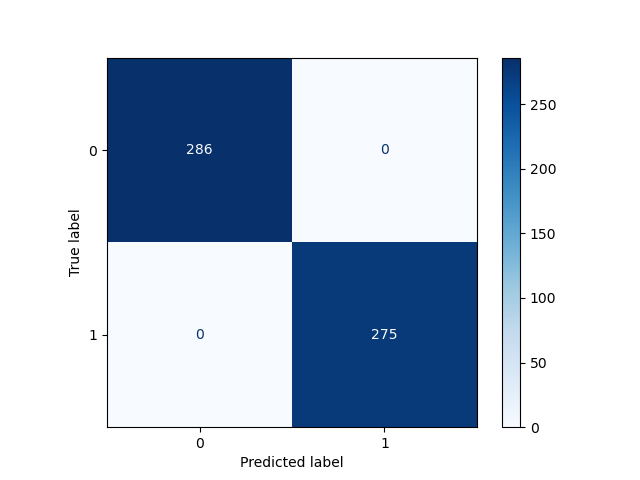

In [12]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

y_pred = RF_Classifier.predict(log_X)

confusionMatrix = confusion_matrix(gender_y, y_pred)
confusionMatrix_display = ConfusionMatrixDisplay(confusionMatrix).plot(cmap='Blues')

The out-of-bag prediction gives a more realistic performance assessment, showing that 33 samples are actually misclassified.

<IPython.core.display.Javascript object>


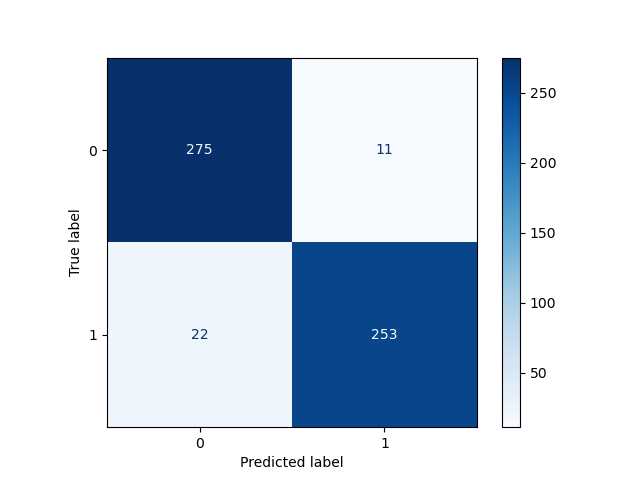

In [13]:
OOB_prediction = [RF_Classifier.classes_[x] for x in np.argmax(RF_Classifier.oob_decision_function_, axis=1)]

confusionMatrix = confusion_matrix(gender_y, OOB_prediction)
confusionMatrix_display = ConfusionMatrixDisplay(confusionMatrix).plot(cmap='Blues')

This difference is even more evident when examining the Receiver-operator-curves taken from the data. The ROC curve obtained with the model prediction has a "perfect" performance! The out-of-bag prediction ROC is still very good, but has a more realistic performance.

<IPython.core.display.Javascript object>


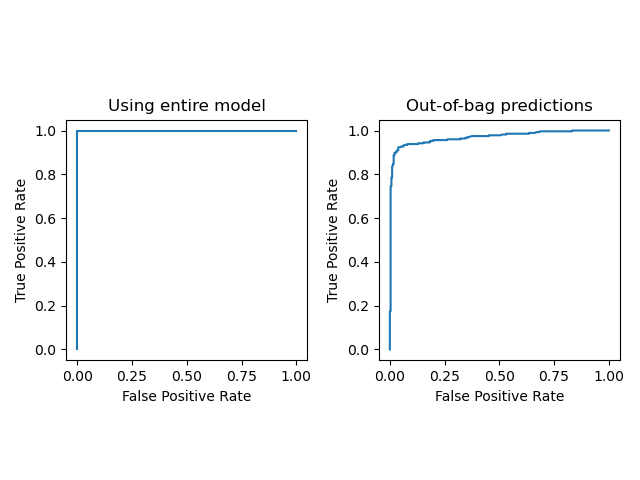

In [14]:
from sklearn.metrics import roc_curve
from sklearn.metrics import RocCurveDisplay

y_score = RF_Classifier.predict_proba(log_X)[:, 1]

fig, ax = plt.subplots(1,2)

fpr, tpr, _ = roc_curve(gender_y, y_score, pos_label= RF_Classifier.classes_[1])
roc_display = RocCurveDisplay(fpr=fpr, tpr=tpr).plot(ax=ax[0])

fpr, tpr, _ = roc_curve(gender_y, RF_Classifier.oob_decision_function_[:, 1], pos_label= RF_Classifier.classes_[1])
roc_display = RocCurveDisplay(fpr=fpr, tpr=tpr).plot(ax[1])

ax[0].set_title('Using entire model')
ax[1].set_title('Out-of-bag predictions')
ax[0].set(adjustable='box', aspect='equal')
ax[1].set(adjustable='box', aspect='equal')

fig.tight_layout()

plt.show()

## 2) Model Selection

In the section above we discussed some of the main parameters of the random forest algorithm and their impact on the type of decision trees generated. 

The parameters described above can be optimized using cross-validation. In this way, we select the set of parameters providing the best results assessed on left-out test sets, not on the training set. Unlike PLS and PCA models, where the only parameters are the number of components and potentially the scaling choice, here there are multiple parameters to test, resulting in a larger combinatorial search space.

This parameter optimization is handled in the next cells using scikit-learn's [GridSearchCV](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html) object. Using this interface, we defined a grid of reasonable parameter values to be tested and optimized, using the performance on CV test sets as the metric to decide the best parameters.

In [15]:
paramGrid = {'max_depth': [None, 5, 10],
             'max_features': ["auto", "sqrt", 5],
             'min_samples_leaf': [2, 5, 10, 100],
             'n_estimators': [250]}

RF_Classifier = RandomForestClassifier()
cvObject = StratifiedKFold(n_splits=7, random_state=1256, shuffle=True)
bestParamSearch = GridSearchCV(estimator=RF_Classifier, param_grid=paramGrid, cv=cvObject, n_jobs=8)

bestParamSearch.fit(log_X, gender_y)

GridSearchCV(cv=StratifiedKFold(n_splits=7, random_state=1256, shuffle=True),
             estimator=RandomForestClassifier(), n_jobs=8,
             param_grid={'max_depth': [None, 5, 10],
                         'max_features': ['auto', 'sqrt', 5],
                         'min_samples_leaf': [2, 5, 10, 100],
                         'n_estimators': [250]})

After selecting the best number of parameters, we can perform cross-validation again to get a better idea of the generalization performance of the model with the best parameters.

In [16]:
finalRFModel = bestParamSearch.best_estimator_

cvObject = StratifiedKFold(n_splits=7, random_state=1256, shuffle=True)
cvScores = cross_validate(finalRFModel, X=log_X, y=gender_y, cv=cvObject, scoring={'auc':'roc_auc', 'accuracy':'accuracy'}, n_jobs=8)

<IPython.core.display.Javascript object>


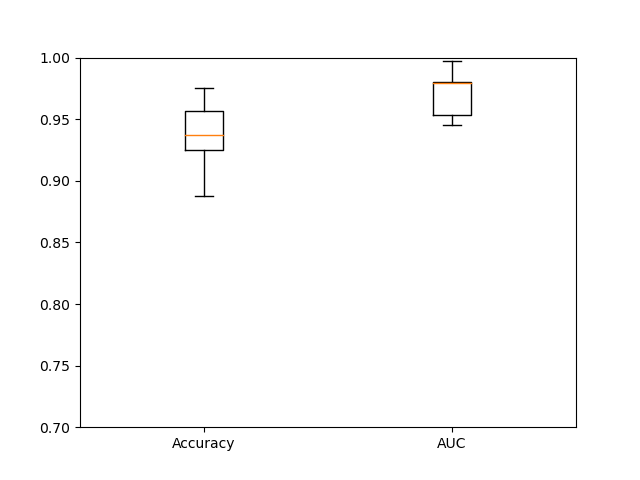

(0.7, 1.0)

In [17]:
fig, ax = plt.subplots()
ax.boxplot([cvScores['test_accuracy'], cvScores['test_auc']])
ax.set_xticklabels(['Accuracy', 'AUC']) 
ax.set_ylim(0.7, 1)

Since this dataset has a large number of observations (561), we can further improve the robustness of the parameter selection and model evaluation by using a nested or [double cross-validation scheme](https://link.springer.com/article/10.1007/s11306-011-0330-3).

In a nested, or double cross-validation scheme the data is first split into a training and a test set, in an "outer" cv loop. The test set is kept aside. Then, the training test is used to optimize the model parameters. These are optimized not by taking the entire training set and fitting the model, but by using an "inner" cv loop, where the initial training data is again partitioned into independent training and test sets. Models with varying parameters are fitted in the "inner" training sets, and their performance benchmarked in the "inner" cv loop test sets. Then, parameters which give the best performance are selected, a model fitted on the entire training set. This model is tested on the test set kept aside in the "outer" cv loop. 

**Note**: Model cross-validation, especially *double cross validation* such as the one executed in the next cell requires fitting the model multiple times, and can take a few minutes. For reference, execution of the next cell takes (pproximately 15 mins on a desktop PC with 8 cores).
13min 7s ± 13.7 s per loop (mean ± std. dev. of 7 runs, 1 loop each)

In [18]:
# Select a set of parameters to test
# n_estimators is fixed at 250
paramGrid = {'max_depth': [None, 5, 10],
             'max_features': ["auto", "sqrt", 5],
             'min_samples_leaf': [2, 5, 10, 100],
             'n_estimators': [250]}

# Statified KFold validation inner and outer CV loops
innerCv = StratifiedKFold(n_splits=7, random_state=1426, shuffle=True)
outerCv = StratifiedKFold(n_splits=7, random_state=7547, shuffle=True)

# Perform a test on the pre-specified set of parameters with KFold cross-validation
innerCV_paramSearch = GridSearchCV(estimator=RF_Classifier, param_grid=paramGrid, cv=innerCv, n_jobs=1)

# Run the nested CV procedure
nestedCVScores = cross_validate(innerCV_paramSearch, log_X, gender_y, scoring='roc_auc', cv=outerCv, n_jobs=8)

<IPython.core.display.Javascript object>


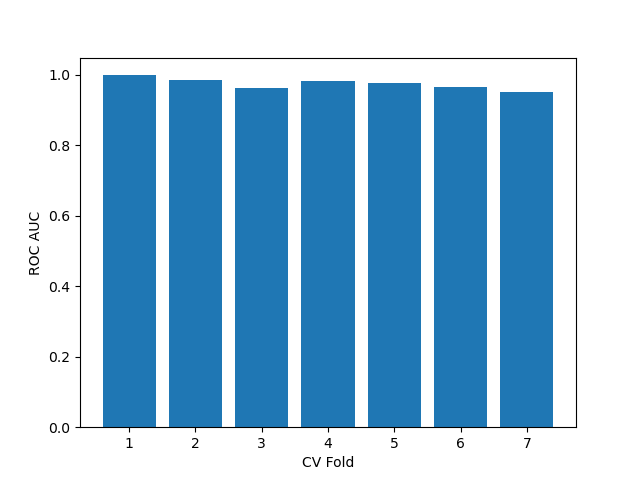

In [19]:
fig, ax = plt.subplots(1) 

ax.bar(x=range(1, len(nestedCVScores['test_score']) + 1), height=nestedCVScores['test_score'])
# ax.set_title('ROC AUC obtained in the external test sets')
ax.set_xlabel('CV Fold')
ax.set_ylabel('ROC AUC')
plt.show()

The ROC AUC values over the multiple nested accross the "outer" test sets in the double cross-validation procedures are very similar.

### Fit the model with best parameters on all data

In [20]:
innerCV_paramSearch = GridSearchCV(estimator=RF_Classifier, param_grid=paramGrid, cv=innerCv, n_jobs=8)
innerCV_paramSearch.fit(log_X, gender_y)

GridSearchCV(cv=StratifiedKFold(n_splits=7, random_state=1426, shuffle=True),
             estimator=RandomForestClassifier(), n_jobs=8,
             param_grid={'max_depth': [None, 5, 10],
                         'max_features': ['auto', 'sqrt', 5],
                         'min_samples_leaf': [2, 5, 10, 100],
                         'n_estimators': [250]})

In [21]:
finalRFClassifier = innerCV_paramSearch.best_estimator_

The performance in a classification task is more effectively described by confusion matrices and related metrics, such as accuracy/balanced accuracy, f1, ROC curves and their respective area under the curve.

To obtain more reliable estimates we can calculate the cross-validation estimates of any of these metrics, including cross-validated ROC curves. This ROC curve was estimated using the left-out samples (the test sets) during cross-validation.

<IPython.core.display.Javascript object>


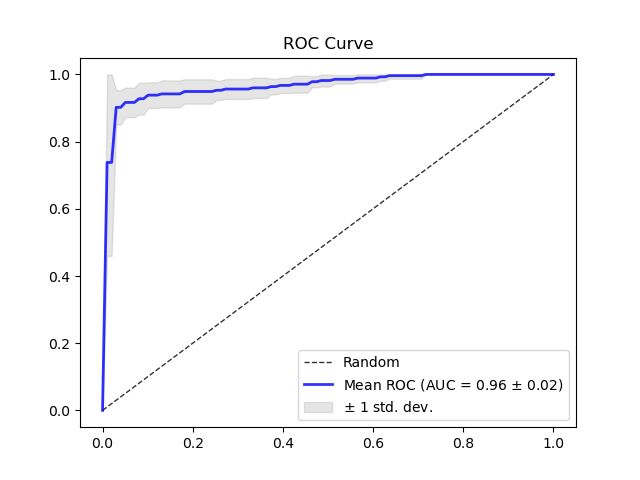

In [22]:
tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 100)


for train_idx, test_idx in cvObject.split(log_X, gender_y):
    
    finalRFModel.fit(log_X[train_idx], gender_y[train_idx])
    currentProbScore = finalRFModel.predict_proba(log_X[test_idx])
    
    fpr, tpr, thresholds = roc_curve(gender_y[test_idx], currentProbScore [:, 1], pos_label='Male')
    interp_tpr = np.interp(mean_fpr, fpr, tpr)
    interp_tpr[0] = 0.0
    roc_auc = auc(fpr, tpr)
    tprs.append(interp_tpr)
    aucs.append(roc_auc)

    
fig, ax = plt.subplots(1)

ax.plot([0, 1], [0, 1], linestyle='--', lw=1, color='k', label='Random', alpha=.8)

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)

std_auc = np.std(aucs)

ax.plot(mean_fpr, mean_tpr, color='b',
        label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
        lw=2, alpha=.8)

std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
ax.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                label=r'$\pm$ 1 std. dev.')

ax.set(xlim=[-0.05, 1.05], ylim=[-0.05, 1.05],
       title="ROC Curve")
ax.legend(loc="lower right")
plt.show()

### Permutation Testing

A final and very important method for model validation is the permutation randomization test. In a permutation randomisation test, the model will be refitted and assessed multiple times, but each time with the Y randomly permuted to destroy any relationship between X & Y. This allows us to assess what sort of model we can get when there really is no relationship between the two data matrices, and calculate the likelihood of obtaining a model with predictive performance as good as the non-permuted model by chance alone.

During this test, the parameters chosen during the cross-validation set, and any other modeling choices, are kept constant. In each randomization, the model is refitted, and the AUC and other validation metrics are recorded. This enables the generation of permuted null distributions for any parameter, which can be used to obtain an empirical *p-value* for their significance.

**Note** Running the permutation test with a large number of permutation randomizations (for example, 1000) is expected to take a considerable ammount of time (approximately 1h10 mins on an desktop PC with 8 cores).

In [ ]:
# Prepare the cv object
permutationCV = StratifiedKFold(n_splits=7, random_state=553, shuffle=True)

permutationScore, permutationScores, permutationPvalue = permutation_test_score(finalRFClassifier, log_X, gender_y, scoring="roc_auc", cv=permutationCV, n_permutations=5, n_jobs=16)

In [ ]:
# plot the results from the permuation test
fig, ax = plt.subplots()
ax.hist(permutationScores, 100)
ax.axvline(permutationScore, ymin=0, ymax=1, linestyle='--')
plt.xlabel('ROC AUC')
plt.ylabel('Counts')
print("Permutation p-value for the AUC: {0:f}".format(permutationPvalue))

The *p-value* obtained is < 0.05, so the model's ROC AUC values are significantly different from what is expected by chance alone at a level of $\alpha$ = 0.05.

## 3) Model interpretation and variable importance

Random forest classifiers have their own specific metrics to assess how important each individual feature is to the model predictive performance. 

The main variable importance metric is the Gini importance measure. This metric is always positive, and the higher the value the higher the "importance" of the feature.

**Warning**: The ammount of multicollinerity between variables can impact the magnitude of [RF importance metrics](https://academic.oup.com/bioinformatics/article/27/14/1986/194387). Also, as in PLS models, the varible importance metrics for random forest algorithms should also be mainly used to rank the variables. Determining whether a variable is "statistically significant" is not straightforward, and a univariate analysis should be performed in parallel.

Plot the RF variable importance metric in 2D

In [ ]:
from pyChemometrics.plotting_utils import _scatterplots
_scatterplots(finalRFClassifier.feature_importances_, xaxis=retention_times, yaxis=mz_values)

In [ ]:
# Save results to disk
RFFeatureImportances = pds.DataFrame(np.c_[variable_names, finalRFClassifier.feature_importances_], columns=['Variable', 'RFImportance'])
RFFeatureImportances.to_csv('./Data/LC_MS_RFImportance.csv', index=False)

In [ ]:
fig, ax = plt.subplots()
ax = ax.hist(RFFeatureImportances.loc[RFFeatureImportances['RFImportance'] != 0, 'RFImportance'], 100)

### Comparison between variables highlighted in a multivariate PLS-DA analysis with an equivalent Random Forest analysis.

The following cells should be run after completing the analyses described in the **Discrimination of biological sex from urinary metabolic profiles using Partial Least Squares – Discriminant Analysis** Jupyter Notebook.

Load the results from the PLS-DA modeling of the same dataset.

In [ ]:
#load the results from the PLS-DA analysis
plsDA_Results = pds.read_csv('./Data/LC_MS_PLSDA_VarImportance.csv')

Scatterplot between the PLS regression coefficients and the RF feature importance.

In [ ]:
fig, ax = plt.subplots()
ax.scatter(plsDA_Results['Beta'], finalRFClassifier.feature_importances_)
ax.set_xlabel('\u03B2')
ax.set_ylabel('RF Importance')
plt.show()

In [ ]:
top20_PLS = plsDA_Results.loc[np.argsort(np.abs(plsDA_Results['Beta']))[::-1]].iloc[0:20]
top20_RF = RFFeatureImportances.loc[np.argsort(RFFeatureImportances['RFImportance'])[::-1]].iloc[0:20]

shared_npeaks = sum(top20_PLS['Feature Name'].isin(top20_RF['Variable']))

print("Number of shared peaks in the top 20 shared between PLS-DA and RF classifier: {0}".format(shared_npeaks))

top20_PLS.loc[top20_PLS['Feature Name'].isin(top20_RF['Variable']), 'Feature Name']